In [1]:
%matplotlib inline

import zipfile
import io
import csv
import time
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with zipfile.ZipFile('toy.zip') as zf:
    with zf.open('toy.csv') as f:
        sf = io.TextIOWrapper(f)
        reader = csv.reader(sf)
        next(reader)
        tm = []
        for row in reader:
            tm.append([float(v) for v in row])
        tm = np.array(tm, dtype=np.float32)

print('Data: {} exemplars, {} features'.format(tm.shape[0], tm.shape[1]))
shuffle(tm)
split = int(tm.shape[0] * 0.6)

toy_train_data = tm[:split,:]
toy_test_data = tm[split:,:]

mtr, ntr = toy_train_data.shape
mtt, ntt = toy_test_data.shape

print('Training set size:', toy_train_data.shape[0])
print('Test set size:', toy_test_data.shape[0])

Data: 99 exemplars, 2 features
Training set size: 59
Test set size: 40


In [3]:
# Sum of squarred errors for splitting criterion
def calc_sse(y):
    if(y.shape[0]>0):
        mean_y = np.mean(y)
    else:
        mean_y = 0
    sse = 0
    for i in range(y.shape[0]):
        sse += np.power((mean_y-y[i]),2)
    return sse
    

def find_split(x, y):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""

    # Best thus far, initialised to a dud that will be replaced immediately...
    best = {'SSE' : np.inf}
    #print(best)
    # Loop every possible split of every dimension...
    for i in range(x.shape[1]):
        for split in np.unique(x[:,i]):
            
            left_indices = np.nonzero(x[:,i] <= split) [0]
            left_sse = calc_sse(y[left_indices])          
            
            right_indices = np.nonzero(x[:,i] > split) [0]
            right_sse = calc_sse(y[right_indices])
            
            SSE = left_sse + right_sse

            if SSE < best['SSE']:
                best = {'feature' : i,
                        'split' : split,
                        'SSE' : SSE, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
#     print(best)
    return best

In [4]:
def build_tree(x, y, y_size, max_depth = np.inf):
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    if max_depth==1 or (y==y[0]).all() or (y.shape[0]/y_size)<=0.05:
        # Generate a leaf node...
#         classes, counts = np.unique(y, return_counts=True)
        if(y.shape[0]>0):
            mean_y = np.mean(y)
        else:
            mean_y = 0
        return {'leaf' : True, 'prediction' : mean_y}
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], y_size,max_depth - 1)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], y_size,max_depth - 1)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'SSE' : move['SSE'],
                'left' : left,
                'right' : right}

In [5]:
def predict(tree, samples):
    """Predicts class for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=int)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['prediction']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

# mean square error
def calc_error(pred, actual):
    ssd = 0
    for i in range(pred.shape[0]):
        subt = pred[i]-actual[i]
        square = np.power(subt,2)
        ssd += square
    return ssd/pred.shape[0]


In [6]:
def bagging(x_train, n):
    bag = np.zeros(shape=(n,x_train.shape[1]))
    indices = np.empty(n, dtype=int)
    for i in range(n):
        index = np.random.randint(0,x_train.shape[0]-1)
        indices[i] = index
    bag = x_train[indices,:]
    return bag, indices

def feat_subset(bag, m):
    random_bag = np.zeros(shape = (bag.shape[0],m))
    indices = np.empty(m, dtype=int)
    indices = np.random.choice(bag.shape[1]-1, m, replace = False)
    random_bag = bag[:,indices]
    return random_bag, indices

def random_forest(x_train, y_train, x_test, y_test, num_trees, max_depth):
    bag = None
    bag_ratio = 0.1
#     max_depth = 11
    n = int(x_train.shape[0]*bag_ratio)
    predictions = np.zeros(y_test.shape)
    for i in range(num_trees):
        bag_x, bag_indices = bagging(x_train,n)
        bag_y = y_train[bag_indices]
        feat_ratio = 0.33# np.random.randint(0,x_train.shape[1],1)/x_train.shape[1]
#         feat_bag_x, feat_indices = feat_subset(bag_x,int(np.ceil(x_train.shape[1]*feat_ratio)))
        this_tree = build_tree(bag_x, bag_y, bag_y.shape[0], max_depth)
        this_prediction = predict(this_tree, x_test)
        predictions += this_prediction
        print('The forest currently constists of {} trees'.format(i+1))
    final_predictions = predictions/num_trees
    MSE = calc_error(final_predictions, y_test)
    
    print('For a forest of {} trees, the final test MSE equals to {}'.format(num_trees,MSE))
    return MSE, final_predictions

The forest currently constists of 1 trees
The forest currently constists of 2 trees
The forest currently constists of 3 trees
The forest currently constists of 4 trees
The forest currently constists of 5 trees
The forest currently constists of 6 trees
The forest currently constists of 7 trees
The forest currently constists of 8 trees
The forest currently constists of 9 trees
The forest currently constists of 10 trees
The forest currently constists of 11 trees
The forest currently constists of 12 trees
The forest currently constists of 13 trees
The forest currently constists of 14 trees
The forest currently constists of 15 trees
The forest currently constists of 16 trees
The forest currently constists of 17 trees
The forest currently constists of 18 trees
The forest currently constists of 19 trees
The forest currently constists of 20 trees
The forest currently constists of 21 trees
The forest currently constists of 22 trees
The forest currently constists of 23 trees
The forest currently

The forest currently constists of 236 trees
The forest currently constists of 237 trees
The forest currently constists of 238 trees
The forest currently constists of 239 trees
The forest currently constists of 240 trees
The forest currently constists of 241 trees
The forest currently constists of 242 trees
The forest currently constists of 243 trees
The forest currently constists of 244 trees
The forest currently constists of 245 trees
The forest currently constists of 246 trees
The forest currently constists of 247 trees
The forest currently constists of 248 trees
The forest currently constists of 249 trees
The forest currently constists of 250 trees
The forest currently constists of 251 trees
The forest currently constists of 252 trees
The forest currently constists of 253 trees
The forest currently constists of 254 trees
The forest currently constists of 255 trees
The forest currently constists of 256 trees
The forest currently constists of 257 trees
The forest currently constists o

The forest currently constists of 480 trees
The forest currently constists of 481 trees
The forest currently constists of 482 trees
The forest currently constists of 483 trees
The forest currently constists of 484 trees
The forest currently constists of 485 trees
The forest currently constists of 486 trees
The forest currently constists of 487 trees
The forest currently constists of 488 trees
The forest currently constists of 489 trees
The forest currently constists of 490 trees
The forest currently constists of 491 trees
The forest currently constists of 492 trees
The forest currently constists of 493 trees
The forest currently constists of 494 trees
The forest currently constists of 495 trees
The forest currently constists of 496 trees
The forest currently constists of 497 trees
The forest currently constists of 498 trees
The forest currently constists of 499 trees
The forest currently constists of 500 trees
The forest currently constists of 501 trees
The forest currently constists o

The forest currently constists of 758 trees
The forest currently constists of 759 trees
The forest currently constists of 760 trees
The forest currently constists of 761 trees
The forest currently constists of 762 trees
The forest currently constists of 763 trees
The forest currently constists of 764 trees
The forest currently constists of 765 trees
The forest currently constists of 766 trees
The forest currently constists of 767 trees
The forest currently constists of 768 trees
The forest currently constists of 769 trees
The forest currently constists of 770 trees
The forest currently constists of 771 trees
The forest currently constists of 772 trees
The forest currently constists of 773 trees
The forest currently constists of 774 trees
The forest currently constists of 775 trees
The forest currently constists of 776 trees
The forest currently constists of 777 trees
The forest currently constists of 778 trees
The forest currently constists of 779 trees
The forest currently constists o

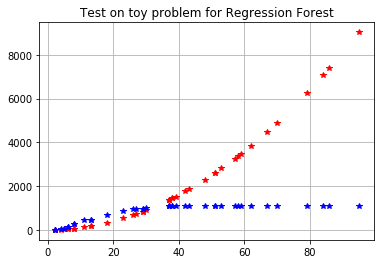

In [9]:
toy_MSE, toy_preds = random_forest(toy_train_data[:,:ntr-1],toy_train_data[:,-1],toy_test_data[:,:ntt-1],toy_test_data[:,-1],1000,np.inf)
print(toy_MSE)
toy_mse2 = calc_error(toy_preds, toy_test_data[:,-1])
print(toy_mse2)

plt.plot(toy_test_data[:,:ntt-1],toy_test_data[:,-1],'r*')
plt.plot(toy_test_data[:,:ntt-1],toy_preds,'b*')
plt.title('Test on toy problem for Regression Forest')
plt.grid(True)
plt.show()